In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[2 1 0 2 0 0 1 2 1 1 0 1 2 1 2 0 2 2 2 1 1 0 2 0 0 0 2 0 1 0 0 1]


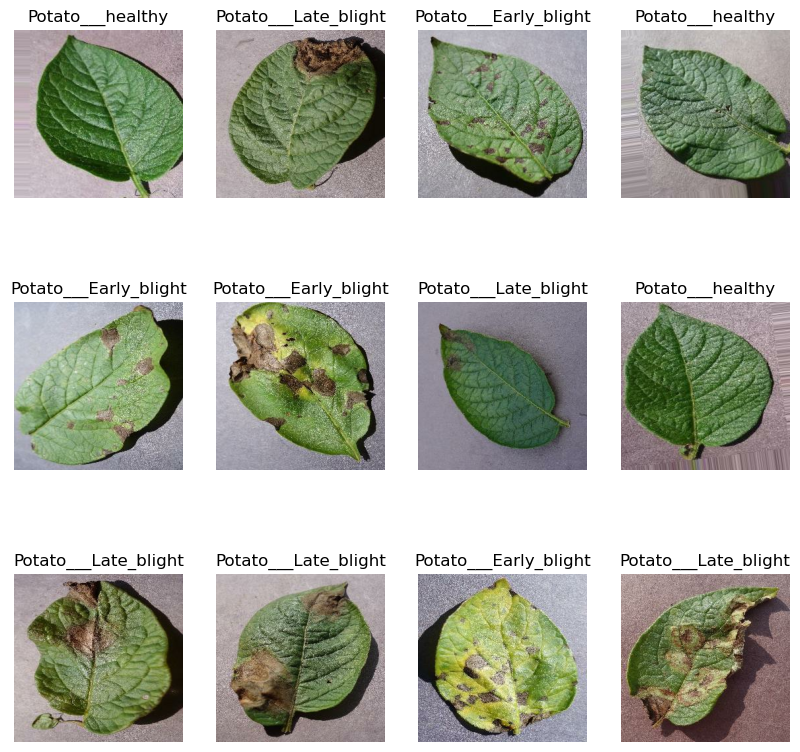

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
37/37 [==============================] - 44s 1s/step - loss: 1.0885 - accuracy: 0.3576 - val_loss: 1.0094 - val_accuracy: 0.6719
Epoch 2/20
37/37 [==============================] - 45s 1s/step - loss: 0.6770 - accuracy: 0.6780 - val_loss: 0.4508 - val_accuracy: 0.8047
Epoch 3/20
37/37 [==============================] - 45s 1s/step - loss: 0.4977 - accuracy: 0.7780 - val_loss: 0.4465 - val_accuracy: 0.8047
Epoch 4/20
37/37 [==============================] - 45s 1s/step - loss: 0.3765 - accuracy: 0.8339 - val_loss: 0.3072 - val_accuracy: 0.8906
Epoch 5/20
37/37 [==============================] - 45s 1s/step - loss: 0.4052 - accuracy: 0.8390 - val_loss: 0.5964 - val_accuracy: 0.7188
Epoch 6/20
37/37 [==============================] - 45s 1s/step - loss: 0.3293 - accuracy: 0.8737 - val_loss: 0.2232 - val_accuracy: 0.9297
Epoch 7/20
37/37 [==============================] - 45s 1s/step - loss: 0.2419 - accuracy: 0.9076 - val_loss: 0.1981 - val_accuracy: 0.9062
Epoch 8/20
37/37 [==

In [13]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 2s 226ms/step - loss: 0.0835 - accuracy: 0.9740


[0.08346224576234818, 0.9739583134651184]

In [14]:
history.history['loss']

[1.0884944200515747,
 0.6769766807556152,
 0.49774521589279175,
 0.37653812766075134,
 0.4052249789237976,
 0.32926180958747864,
 0.24194234609603882,
 0.2695898115634918,
 0.26659032702445984,
 0.1903054565191269,
 0.19537700712680817,
 0.18126757442951202,
 0.14792662858963013,
 0.12009119242429733,
 0.09619931131601334,
 0.1280384063720703,
 0.07324878871440887,
 0.09369494765996933,
 0.08793220669031143,
 0.06046958640217781]

In [15]:
history.history['accuracy']

[0.35762712359428406,
 0.6779661178588867,
 0.7779660820960999,
 0.8338983058929443,
 0.8389830589294434,
 0.8737288117408752,
 0.9076271057128906,
 0.8949152827262878,
 0.8974575996398926,
 0.9288135766983032,
 0.9177966117858887,
 0.9364407062530518,
 0.941525399684906,
 0.9576271176338196,
 0.9635593295097351,
 0.9533898234367371,
 0.9711864590644836,
 0.9644067883491516,
 0.9694915413856506,
 0.9788135886192322]

In [16]:
history.history['val_loss']

[1.0094259977340698,
 0.4508070945739746,
 0.44647401571273804,
 0.30724456906318665,
 0.5964308977127075,
 0.22319039702415466,
 0.19809719920158386,
 0.4426630437374115,
 0.22433097660541534,
 0.2740851044654846,
 0.29327768087387085,
 0.22596375644207,
 0.0815204605460167,
 0.10064400732517242,
 0.10132941603660583,
 0.07274892181158066,
 0.07408788055181503,
 0.09473440051078796,
 0.04509122669696808,
 0.023901162669062614]

In [17]:
history.history['val_accuracy']

[0.671875,
 0.8046875,
 0.8046875,
 0.890625,
 0.71875,
 0.9296875,
 0.90625,
 0.84375,
 0.8828125,
 0.875,
 0.8984375,
 0.8984375,
 0.96875,
 0.96875,
 0.9453125,
 0.9609375,
 0.96875,
 0.9765625,
 0.9921875,
 1.0]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

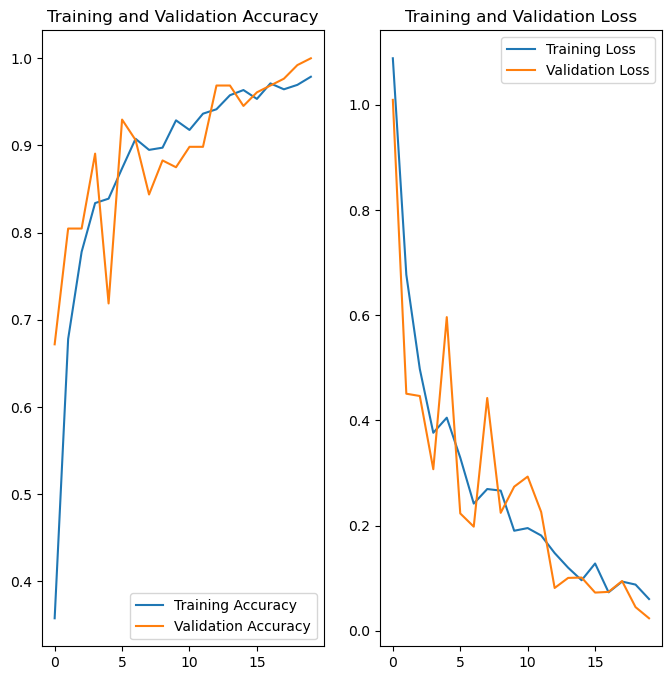

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [20]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 265ms/step


In [21]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


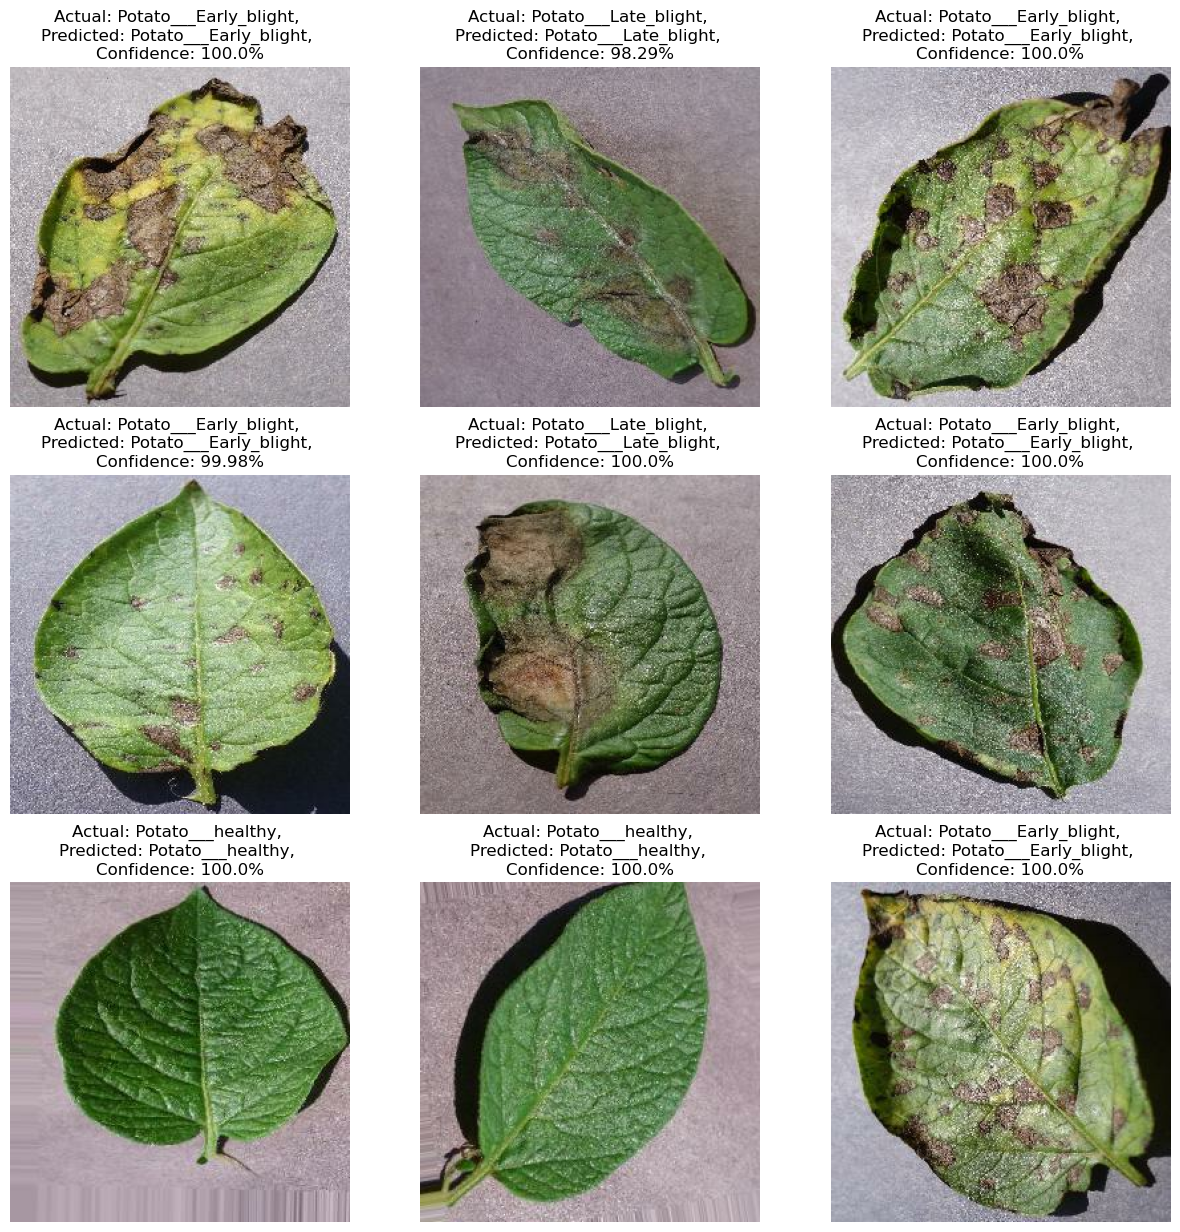

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [23]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        77
           1       0.98      0.94      0.96        62
           2       0.98      1.00      0.99        53

    accuracy                           0.97       192
   macro avg       0.98      0.97      0.97       192
weighted avg       0.97      0.97      0.97       192



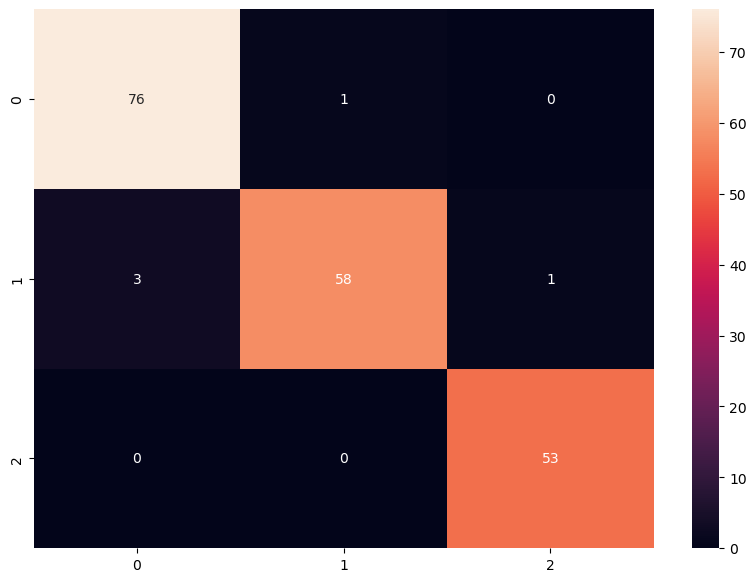

In [24]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [25]:
filename = "Model1-2-DatasetSplit80-10-10.joblib"
joblib.dump(model, filename)

['Model1-2-DatasetSplit80-10-10.joblib']